In [ ]:
# Statoil kaggle challenge, exploration and trials
# https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/data

In [22]:
import numpy as np
import pandas as pd
from scipy import ndimage

from skimage.color import rgb2gray
from scipy.fftpack import fftn, ifftn, fft2, ifft2, fftshift

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pylab
import seaborn as sns

eps = np.finfo(float).eps

import os
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
# Load the training data
train = pd.read_json("data/train.json")

In [3]:
train.head()

band_1  \
0  [-27.878361, -27.15416, -28.668615, -29.537971...   
1  [-12.242375, -14.920305, -14.920363, -12.66633...   
2  [-24.603676, -24.603714, -24.871029, -23.15277...   
3  [-22.454607, -23.082819, -23.998013, -23.99805...   
4  [-26.006956, -23.164886, -23.164886, -26.89116...   

                                              band_2        id inc_angle  \
0  [-27.154118, -29.537888, -31.0306, -32.190483,...  dfd5f913   43.9239   
1  [-31.506321, -27.984554, -26.645678, -23.76760...  e25388fd   38.1562   
2  [-24.870956, -24.092632, -20.653963, -19.41104...  58b2aaa0   45.2859   
3  [-27.889421, -27.519794, -27.165262, -29.10350...  4cfc3a18   43.8306   
4  [-27.206915, -30.259186, -30.259186, -23.16495...  271f93f4   35.6256   

   is_iceberg  
0           0  
1           0  
2           1  
3           0  
4           0

#### False colouring ####

In [4]:
b1_ship = np.asarray(train['band_1'].loc[0]).reshape((75, 75))
b2_ship = np.asarray(train['band_2'].loc[0]).reshape((75, 75))
b1_iceb = np.asarray(train['band_1'].loc[2]).reshape((75, 75))
b2_iceb = np.asarray(train['band_2'].loc[2]).reshape((75, 75))

In [40]:
def log_fft(im):
    F = np.log(np.abs(fftshift(fft2(im)**2)) + eps)
    return F


def get_phase(im):
    return np.arctan2(np.imag(fft2(im)), np.real(fft2(im)))


def local_var(im, size):
    mu = ndimage.uniform_filter(im, (size, size))
    mu_square = ndimage.uniform_filter(im**2, (size, size))
    return mu_square - (mu ** 2)


def weight_filter(image):
    norm_im = norm_channel(image)
    lvar_im = local_var(local_var(norm_im, 5), 9)
    
    return norm_channel(lvar_im * norm_im)


def threshold(y, t):
    return np.clip(y-t, 0, None)


def wave_noise(image):

    noise_var = np.std(image.ravel()) ** 2
    
    lvar = threshold(local_var(image, 3), noise_var)
    roi = [5, 7, 9]
    for sz in roi:
        est_var = threshold(local_var(image, sz), noise_var)
        lvar = np.minimum(est_var, lvar)
        
    noise_coef = image * noise_var / (lvar + noise_var)

    return noise_coef


def norm_channel(image):
    low, high = image.min(),image.max()
    return (image - low) / (high - low)


def logshift(im):
    
    if len(im.shape) == 2:
        low = im.min()
        print(low)
        im = np.clip(im + np.abs(low), 0.05, None)
        im = np.log(im + eps)
        return im

    for i in range(im.shape[-1]):
        low = im[:, :, i].min()
        print(low)
        im[:, :, i] = np.clip(im[:, :, i] + np.abs(low), 0.05, None)
        im[:, :, i] = np.log(im[:, :, i] + eps)
    return im        


def min_shift(im):
    
    if len(im.shape) == 2:
        low = im.min()
        print(low)
        im = im + np.abs(low) + eps
        return im

    for i in range(im.shape[-1]):
        low = im[:, :, i].min()
        im[:, :, i] = im[:, :, i] + np.abs(low) + eps
    return im  


# Nifty function to have correctly sized colorbars in sub figures. 
# Credit:
# http://joseph-long.com/writing/colorbars/
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)
    

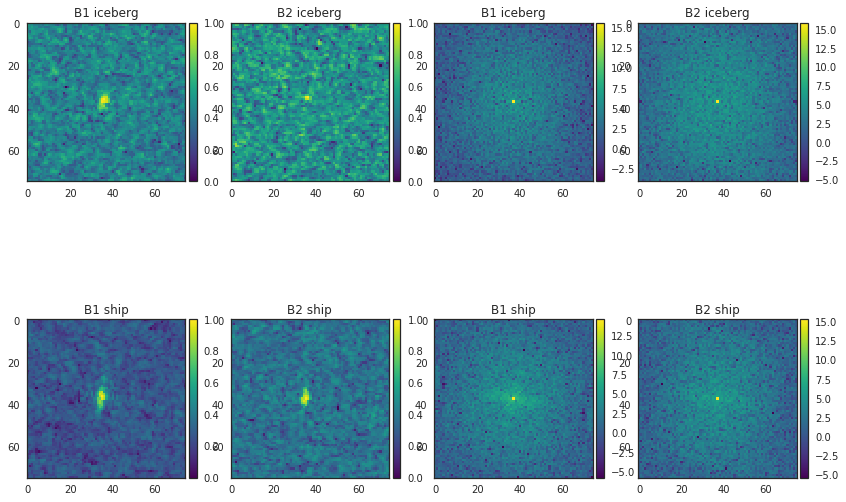

In [13]:
plt.rcParams['figure.figsize'] = 14, 10
with sns.axes_style('white'):
    f, axis = plt.subplots(nrows=2, ncols=4)
    
    im = axis[0, 0].imshow(norm_channel(b1_iceb), cmap='viridis')
    colorbar(im)
    axis[0, 0].set_title('B1 iceberg')
    
    im = axis[0, 1].imshow(norm_channel(b2_iceb), cmap='viridis')
    colorbar(im)
    axis[0, 1].set_title('B2 iceberg')
    
    im = axis[0, 2].imshow(log_fft(norm_channel(b1_iceb)), cmap='viridis')
    colorbar(im)
    axis[0, 2].set_title('B1 iceberg')

    im = axis[0, 3].imshow(log_fft(norm_channel(b2_iceb)), cmap='viridis')
    colorbar(im)
    axis[0, 3].set_title('B2 iceberg')

    im = axis[1, 0].imshow(norm_channel(b1_ship), cmap='viridis')
    colorbar(im)
    axis[1, 0].set_title('B1 ship')
    
    im = axis[1, 1].imshow(norm_channel(b2_ship), cmap='viridis')
    colorbar(im)
    axis[1, 1].set_title('B2 ship')
    
    im = axis[1, 2].imshow(log_fft(norm_channel(b1_ship)), cmap='viridis')
    colorbar(im)
    axis[1, 2].set_title('B1 ship')

    im = axis[1, 3].imshow(log_fft(norm_channel(b2_ship)), cmap='viridis')
    colorbar(im)
    axis[1, 3].set_title('B2 ship')


Text(0.5,1,u'B2 ship')

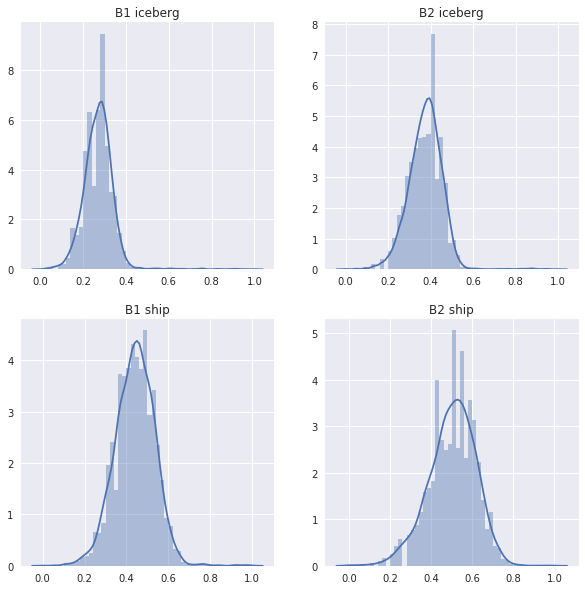

In [11]:
sns.set()

plt.rcParams['figure.figsize'] = 10, 10

f, axis = plt.subplots(nrows=2, ncols=2)

sns.distplot(b1_ship_n1.ravel(), ax=axis[0, 0])
axis[0, 0].set_title('B1 iceberg')

sns.distplot(b2_ship_n1.ravel(), ax=axis[0, 1])
axis[0, 1].set_title('B2 iceberg')

sns.distplot(b1_iceb_n1.ravel(), ax=axis[1, 0])
axis[1, 0].set_title('B1 ship')

sns.distplot(b2_iceb_n1.ravel(), ax=axis[1, 1])
axis[1, 1].set_title('B2 ship')

In [41]:
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode()

def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [42]:
plotmy3d(b1_ship, 'B1 ship')

In [20]:
plotmy3d(b2_ship, 'B2 ship')

In [101]:
plotmy3d(b1_iceb, 'B1 Iceberg')

In [21]:
plotmy3d(b2_iceb, 'B2 Iceberg')

In [25]:
lvar_b1_ship = local_var(local_var(norm_channel(b1_ship), 5), 9)
lvar_b2_ship = local_var(local_var(norm_channel(b2_ship), 5), 9)
lvar_b1_iceb = local_var(local_var(norm_channel(b1_iceb), 5), 9)
lvar_b2_iceb = local_var(local_var(norm_channel(b2_iceb), 5), 9)

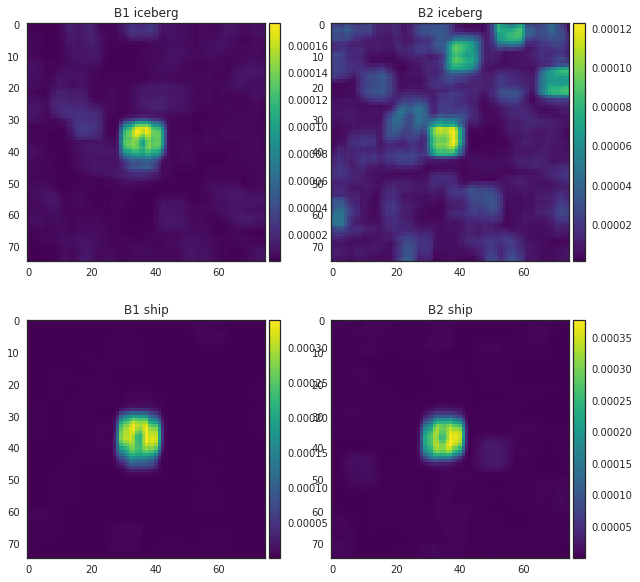

In [26]:
plt.rcParams['figure.figsize'] = 10, 10
with sns.axes_style('white'):
    f, axis = plt.subplots(nrows=2, ncols=2)
    
    im = axis[0, 0].imshow(lvar_b1_iceb, cmap='viridis')
    colorbar(im)
    axis[0, 0].set_title('B1 iceberg')
    
    im = axis[0, 1].imshow(lvar_b2_iceb, cmap='viridis')
    colorbar(im)
    axis[0, 1].set_title('B2 iceberg')
    
    im  = axis[1, 0].imshow(lvar_b1_ship, cmap='viridis')
    colorbar(im)
    axis[1, 0].set_title('B1 ship')
    
    im = axis[1, 1].imshow(lvar_b2_ship, cmap='viridis')
    colorbar(im)
    axis[1, 1].set_title('B2 ship')

In [31]:
plotmy3d(norm_channel(lvar_b1_ship), 'B1 ship')

In [32]:
plotmy3d(weight_filter(b1_ship), 'B1 ship')

In [34]:
plotmy3d(weight_filter(b1_iceb), 'B1 ice')

In [38]:
plotmy3d(weight_filter(b2_iceb), 'B2 ice')